# Stabla odlucivanja

In [73]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import numpy as np
from termcolor import colored

Ucitavanje podataka:

In [74]:
data=pd.read_csv("C:/Users/Administrator/2023_Data_Mining_Coffee_Quality_Dataset/cleaned_data.csv")
data.head()

,Unnamed: 0,Species,Country.of.Origin,Region,Harvest.Year,Variety,Processing.Method,Category.One.Defects,Quakers,Color,Category.Two.Defects,altitude_mean_meters,Total.Cup.Points
0,0,0,8,115,5,5,4,0,0.0,2,0,2075.0,9.0
1,1,0,8,115,5,15,4,0,0.0,2,1,2075.0,9.0
2,2,0,9,122,3,2,4,0,0.0,2,0,1700.0,9.0
3,3,0,8,226,5,5,0,0,0.0,2,2,2000.0,9.0
4,4,0,8,115,5,15,4,0,0.0,2,2,2075.0,9.0


In [75]:
data.drop("Unnamed: 0",axis=1,inplace=True)

Podela na ulazne i ciljne atribute:

In [76]:
Y=data["Total.Cup.Points"]
X=data.drop("Total.Cup.Points",axis=1)
feature_names=X.columns
X.head()

,Species,Country.of.Origin,Region,Harvest.Year,Variety,Processing.Method,Category.One.Defects,Quakers,Color,Category.Two.Defects,altitude_mean_meters
0,0,8,115,5,5,4,0,0.0,2,0,2075.0
1,0,8,115,5,15,4,0,0.0,2,1,2075.0
2,0,9,122,3,2,4,0,0.0,2,0,1700.0
3,0,8,226,5,5,0,0,0.0,2,2,2000.0
4,0,8,115,5,15,4,0,0.0,2,2,2075.0


In [77]:
Y.unique()

array([9., 8., 7., 6., 5., 4.])

Podaci su prilicno nebalansirani

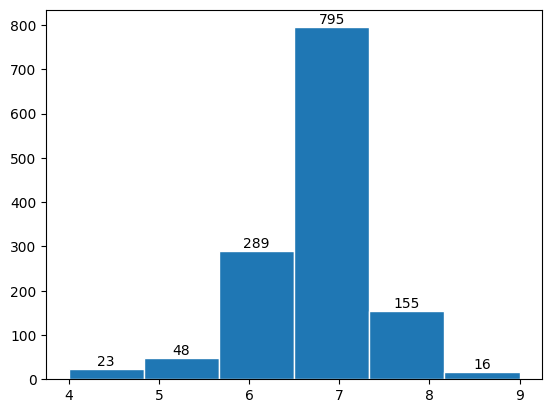

In [78]:
#kod preuzet iz materijala za vezbe
freq, bins, _ = plt.hist(Y,edgecolor='white', bins=6)

bin_centers=np.diff(bins)*0.5+bins[:-1]
for fr, x in zip(freq,bin_centers):
    height=int(fr)
    plt.annotate("{}".format(height),xy=(x,height),xytext = (0,0.2),textcoords = "offset points", ha = 'center', va = 'bottom')

plt.show()

Podela na trening i test skup

In [116]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, stratify=Y, random_state=42)
print(X_train.shape, X_test.shape)

(928, 11) (398, 11)


Pomocne funkcije

In [117]:
#kod preuzet iz materijala
from collections import Counter
from sklearn.decomposition import PCA

def resample(sampler, X, Y):
    X_resampled, y_resampled = sampler.fit_resample(X, Y)
    print(colored("Number of instances before resampling with {} : {}. ".format(type(sampler).__name__,\
                                                                           Counter(Y).items()), "green"))
    print(colored("Number of instances after  resampling with {} : {}. ".format(type(sampler).__name__,\
                                                                           Counter(y_resampled).items()), "blue"))
    return X_resampled, y_resampled
    

In [218]:
def visualize(X, X_resampled, Y, Y_resampled, x_opacity=0.5):
    """
        x_opacity - [0, 1] -> prozirnost elemenata klase (podešavati u odnosu na to da li prikazujemo samo 1 klasu ili obe)
    """
    
    #Da bismo vizuelizovali, iskoristicemo PCA da smanjimo na 2 dimenzije
    
    pca = PCA(n_components=2)
    pca.fit(X)
    
    X_pca = pca.transform(X)
    X_resampled_pca = pca.transform(X_resampled) 
    
    X_stacked = [X_pca, X_resampled_pca]
    Y_stacked = [Y, y_resampled]
    
    fig = plt.figure(figsize=(20, 5))
    
    for i in range(2):
        ax = plt.subplot(1, 2, i + 1)
        colors = ['b' if y == -1 else 'r' for y in Y_stacked[i]]
        alpha = [x_opacity if y == -1 else 1 - x_opacity for y in Y_stacked[i]]
        plt.scatter(X_stacked[i][:, 0], X_stacked[i][:, 1], c=colors, alpha=alpha)
        plt.title('{} resampling'.format("After" if i else "Before"), c = 'blue' if i else 'green')
    plt.show()

In [219]:
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced


def report_imbalanced(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Classification report for model {} on {} data".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(classification_report_imbalanced(y, y_pred, zero_division=True))
    print("---------------------------------------------------------------------------------")
    
    print(colored("Confusion matrix for model {} on {} data ".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(pd.DataFrame(confusion_matrix(y, y_pred),columns=[4,5,6,7,8,9],index=[4,5,6,7,8,9]))
    print("---------------------------------------------------------------------------------")

In [220]:
def train_and_evaluate_model(X_train, Y_train, X_test, Y_test):
    model = DecisionTreeClassifier(max_depth=7, min_samples_split=5, criterion='gini')
    model.fit(X_train, Y_train)
    report_imbalanced(model, X_train, Y_train,"training")
    report_imbalanced(model, X_test, Y_test,"test")
    return model

In [221]:
def plot_decision_tree(model, feature_names):
    plt.figure(figsize=(7, 7))
    plot_tree(model, class_names=['4', '5','6','7','8','9'], feature_names=feature_names, filled=True)
    plt.title("Decision tree of depth {} with {} nodes".format(model.get_depth(), model.get_n_leaves()))

    plt.show()
    print("---------------------------------------------------------------------------------")
    print(colored("Parameters of model {}".format(type(model).__name__), "green"))
    for k, v in model.get_params().items():
        print(colored(k, 'blue'), v)
    
    print("---------------------------------------------------------------------------------")

Pogledajmo kako se ponasa model pre nego sto balansiramo klase

In [222]:
model_dtc=train_and_evaluate_model(X_train,Y_train,X_test,Y_test)

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        4.0       1.00      0.12      1.00      0.22      0.35      0.11        16
        5.0       0.40      0.18      0.99      0.24      0.42      0.16        34
        6.0       0.58      0.45      0.91      0.50      0.64      0.39       202
        7.0       0.71      0.89      0.46      0.79      0.64      0.43       556
        8.0       0.80      0.37      0.99      0.50      0.60      0.34       109
        9.0       1.00      0.55      1.00      0.71      0.74      0.52        11

avg / total       0.69      0.69      0.65      0.66      0.62      0.39       928

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on training data 
-----------------------------

Ocekivani rezultati - nedominante klase su skroz izbacene 

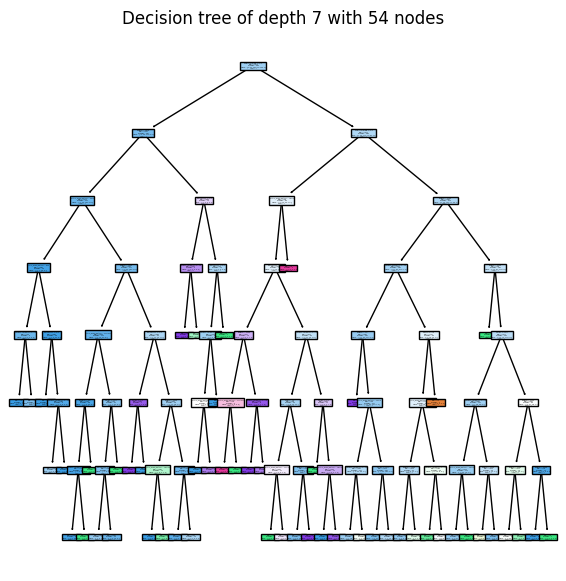

---------------------------------------------------------------------------------
Parameters of model DecisionTreeClassifier
ccp_alpha 0.0
class_weight None
criterion gini
max_depth 7
max_features None
max_leaf_nodes None
min_impurity_decrease 0.0
min_samples_leaf 1
min_samples_split 5
min_weight_fraction_leaf 0.0
random_state None
splitter best
---------------------------------------------------------------------------------


In [223]:
plot_decision_tree(model_dtc,feature_names.tolist())

#### SMOTE

Balansiranje klasa


In [224]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=10, random_state=42)

Number of instances before resampling with SMOTE : dict_items([(7.0, 556), (6.0, 202), (8.0, 109), (9.0, 11), (4.0, 16), (5.0, 34)]). 
Number of instances after  resampling with SMOTE : dict_items([(7.0, 556), (6.0, 556), (8.0, 556), (9.0, 556), (4.0, 556), (5.0, 556)]). 


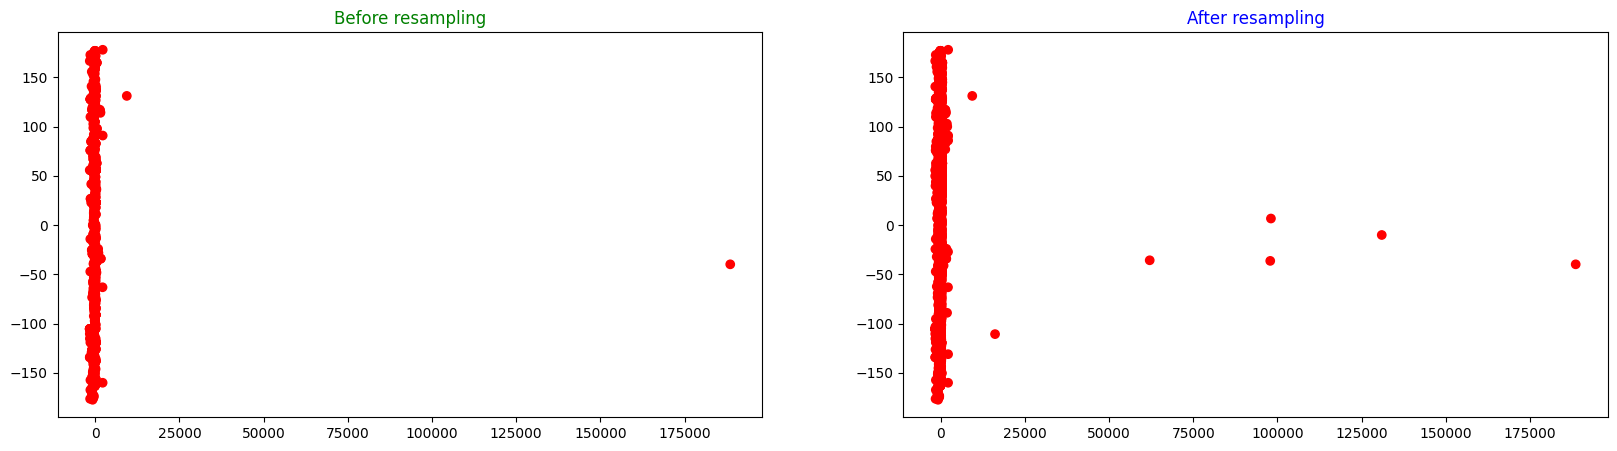

In [225]:
X_resampled, y_resampled = resample(smote, X_train, Y_train)
visualize(X_train, X_resampled, Y_train, y_resampled, 0)

In [226]:
model_smote = train_and_evaluate_model(X_resampled, y_resampled, X_test, Y_test)

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        4.0       0.76      0.76      0.95      0.76      0.85      0.71       556
        5.0       0.48      0.67      0.85      0.56      0.76      0.57       556
        6.0       0.39      0.60      0.81      0.47      0.70      0.47       556
        7.0       0.83      0.11      1.00      0.20      0.34      0.10       556
        8.0       0.60      0.57      0.92      0.58      0.73      0.51       556
        9.0       0.94      0.91      0.99      0.92      0.95      0.89       556

avg / total       0.66      0.60      0.92      0.58      0.72      0.54      3336

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on training data 
-----------------------------

Prilicno lose

Znacaj atributa u formiranju modela

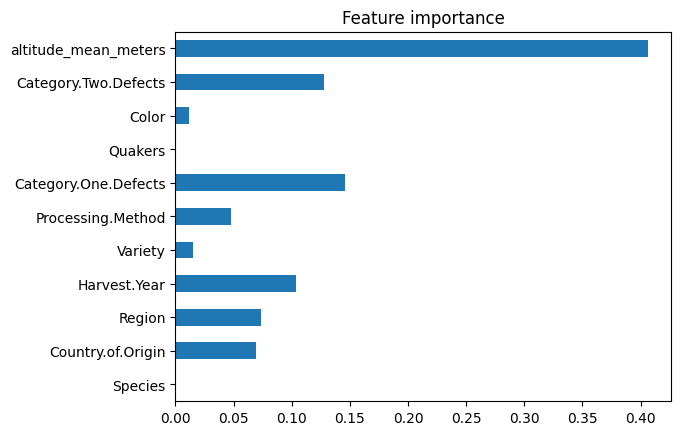

In [227]:
pd.Series(model_smote.feature_importances_, index=feature_names).plot.barh()
plt.title("Feature importance")
plt.show()

#### Podesavanje hiper-parametara

In [228]:
from sklearn.model_selection import GridSearchCV

In [229]:
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [2,4,6,8],
          'min_samples_split' : [2,5,8,10]
         }

In [230]:
estimator = GridSearchCV(DecisionTreeClassifier(), param_grid=params, cv=5)

In [231]:
estimator.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8],
                         'min_samples_split': [2, 5, 8, 10]})

In [232]:
print(estimator.best_params_)
print(estimator.best_score_)


{'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 5}
0.6267984271337385


In [233]:
report_imbalanced(estimator.best_estimator_, X_resampled, y_resampled)

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        4.0       0.85      0.83      0.97      0.84      0.90      0.80       556
        5.0       0.59      0.92      0.87      0.72      0.90      0.81       556
        6.0       0.69      0.28      0.97      0.40      0.52      0.25       556
        7.0       0.48      0.58      0.87      0.53      0.71      0.50       556
        8.0       0.73      0.59      0.96      0.66      0.75      0.55       556
        9.0       0.95      0.97      0.99      0.96      0.98      0.96       556

avg / total       0.72      0.70      0.94      0.68      0.79      0.64      3336

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on training data 
-----------------------------

In [234]:
report_imbalanced(estimator.best_estimator_, X_test, Y_test, "test")

Classification report for model DecisionTreeClassifier on test data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        4.0       0.12      0.43      0.94      0.18      0.64      0.38         7
        5.0       0.09      0.50      0.82      0.16      0.64      0.40        14
        6.0       0.30      0.17      0.89      0.22      0.39      0.14        87
        7.0       0.65      0.46      0.62      0.54      0.54      0.28       239
        8.0       0.23      0.35      0.85      0.28      0.54      0.28        46
        9.0       0.29      0.40      0.99      0.33      0.63      0.37         5

avg / total       0.49      0.38      0.72      0.42      0.51      0.26       398

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on test data 
-------------------------------------

Jako losi rezultati

#### Random forest

In [235]:
from sklearn.ensemble import RandomForestClassifier

params_grid={ 'n_estimators': [100, 200, 300],
                'max_depth': [2, 4 , 6, 8, 10]
                }
estimator2=GridSearchCV(RandomForestClassifier(),param_grid=params_grid)



In [236]:
estimator2.fit(X_resampled,y_resampled)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [100, 200, 300]})

In [237]:
print(estimator2.best_score_)
print(estimator2.best_params_)


0.8123611846771224
{'max_depth': 10, 'n_estimators': 200}


In [238]:
report_imbalanced(estimator2.best_estimator_, X_resampled, y_resampled)

Classification report for model RandomForestClassifier on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        4.0       0.94      0.97      0.99      0.96      0.98      0.96       556
        5.0       0.88      0.97      0.97      0.92      0.97      0.95       556
        6.0       0.89      0.85      0.98      0.87      0.91      0.82       556
        7.0       0.91      0.87      0.98      0.89      0.92      0.84       556
        8.0       0.97      0.90      0.99      0.93      0.95      0.89       556
        9.0       0.98      1.00      1.00      0.99      1.00      1.00       556

avg / total       0.93      0.93      0.99      0.93      0.96      0.91      3336

---------------------------------------------------------------------------------
Confusion matrix for model RandomForestClassifier on training data 
-----------------------------

In [239]:
report_imbalanced(estimator2.best_estimator_, X_test, Y_test)

Classification report for model RandomForestClassifier on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        4.0       0.10      0.29      0.95      0.15      0.52      0.25         7
        5.0       0.07      0.14      0.93      0.10      0.36      0.12        14
        6.0       0.34      0.37      0.80      0.36      0.54      0.28        87
        7.0       0.73      0.62      0.65      0.67      0.63      0.40       239
        8.0       0.35      0.37      0.91      0.36      0.58      0.32        46
        9.0       0.50      0.60      0.99      0.55      0.77      0.57         5

avg / total       0.56      0.51      0.74      0.53      0.60      0.36       398

---------------------------------------------------------------------------------
Confusion matrix for model RandomForestClassifier on training data 
-----------------------------

#### Poredjenje modela

DecisionTree(auc: 0.63)
DecisionTree CV(auc: 0.69)
RandomForest CV(auc: 0.77)
